# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import torch
import torchvision 
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.models import densenet121
from tqdm import tqdm

# Loading The Data

In [2]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 15

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding = 4),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

fashion_dataset = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform_train)

train_size = int(0.8 * len(fashion_dataset))
val_size = len(fashion_dataset) - train_size
train_dataset, val_dataset = random_split(fashion_dataset, [train_size, val_size])

test_dataset = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Checking Unbalance In The Classes

In [4]:
labels = [label for _, label in fashion_dataset]

class_counts = Counter(labels)

sorted_class_counts = sorted(class_counts.items())

for digit, count in sorted_class_counts:
    print(f"Class {digit}: {count} images")

Class 0: 6000 images
Class 1: 6000 images
Class 2: 6000 images
Class 3: 6000 images
Class 4: 6000 images
Class 5: 6000 images
Class 6: 6000 images
Class 7: 6000 images
Class 8: 6000 images
Class 9: 6000 images


## Visualize A Batch Of Training Data

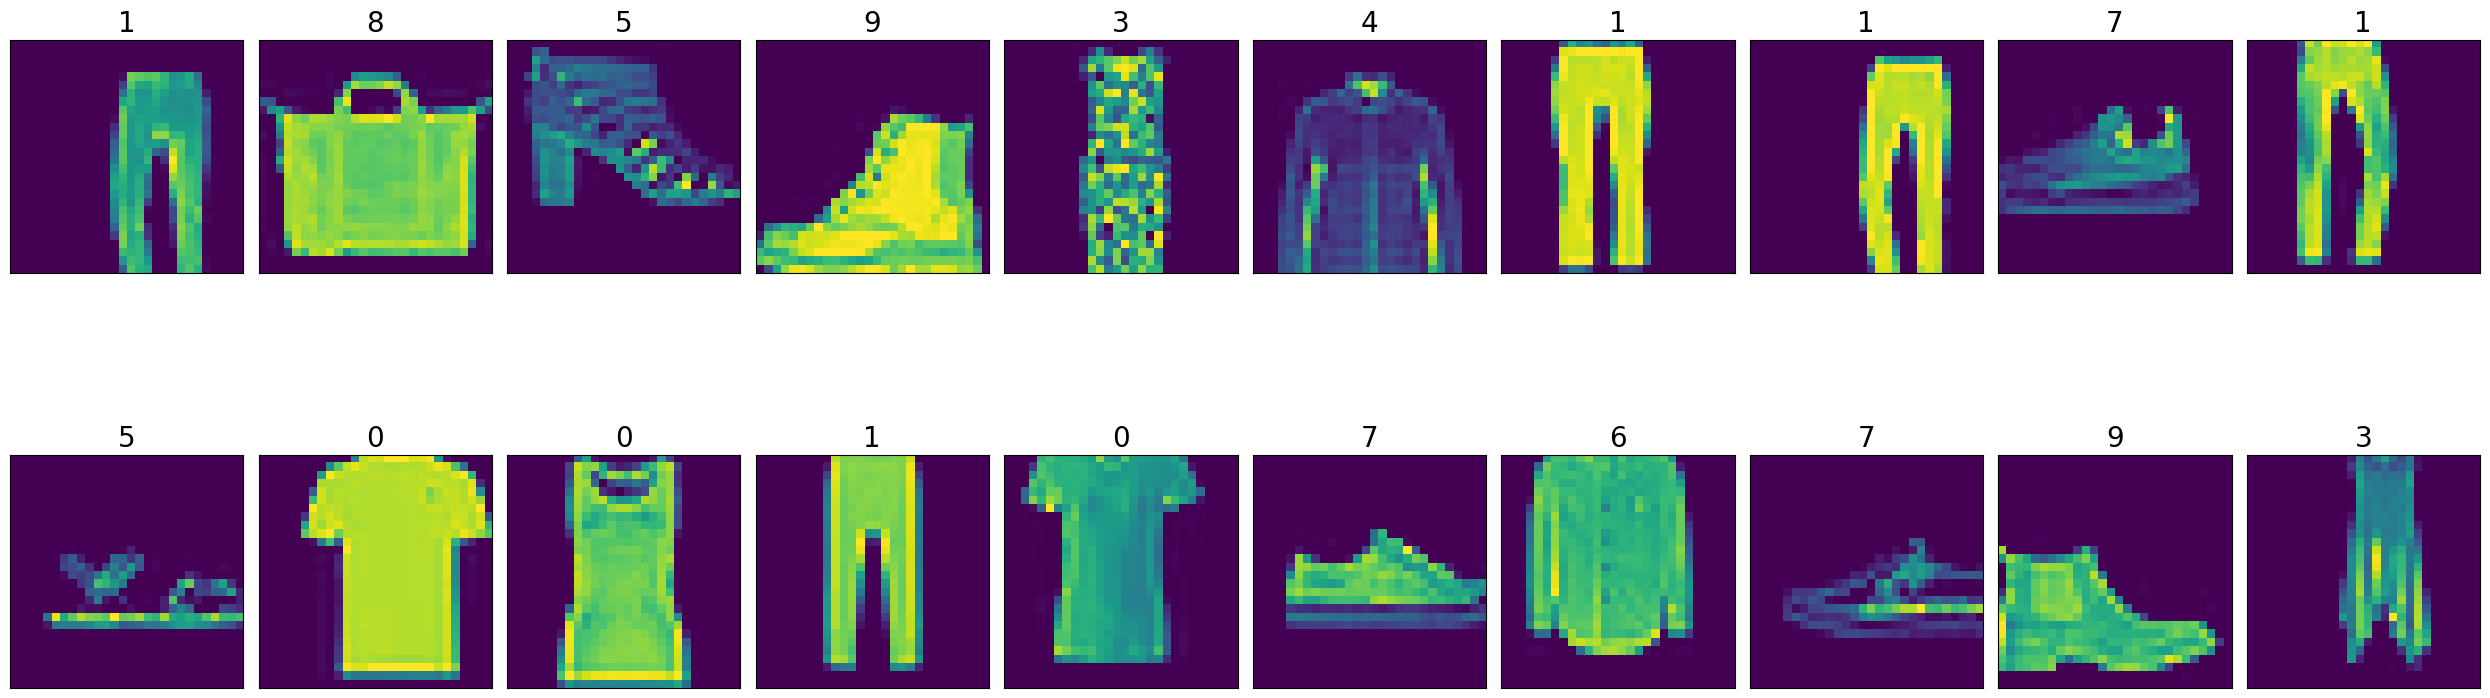

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize = (25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    image = np.transpose(images[idx], (1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[idx].item()), fontsize = 20)

plt.tight_layout()
plt.show()

# Building The Network

In [6]:
class DenseNetBC(nn.Module):
    def __init__(self):
        super(DenseNetBC, self).__init__()
        self.densenet = densenet121()
        
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        
        self.densenet.features.pool0 = nn.Identity()
        
        self.densenet.classifier = nn.Linear(1024, 10)
        
    def forward(self, x):
        return self.densenet(x)

In [7]:
model = DenseNetBC()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr = learning_rate,
)

# Training The Model

In [9]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, targets in tqdm(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device = device)
            targets = targets.to(device = device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

100%|██████████| 750/750 [01:20<00:00,  9.28it/s]


Epoch: 1, Training Loss: 0.521946, Validation Loss: 0.344977


100%|██████████| 750/750 [01:19<00:00,  9.43it/s]


Epoch: 2, Training Loss: 0.332075, Validation Loss: 0.351465


100%|██████████| 750/750 [01:19<00:00,  9.39it/s]


Epoch: 3, Training Loss: 0.285662, Validation Loss: 0.264093


100%|██████████| 750/750 [01:19<00:00,  9.46it/s]


Epoch: 4, Training Loss: 0.260496, Validation Loss: 0.268568


100%|██████████| 750/750 [01:19<00:00,  9.46it/s]


Epoch: 5, Training Loss: 0.240156, Validation Loss: 0.249938


100%|██████████| 750/750 [01:19<00:00,  9.49it/s]


Epoch: 6, Training Loss: 0.224333, Validation Loss: 0.239232


100%|██████████| 750/750 [01:19<00:00,  9.43it/s]


Epoch: 7, Training Loss: 0.211452, Validation Loss: 0.225553


100%|██████████| 750/750 [01:19<00:00,  9.45it/s]


Epoch: 8, Training Loss: 0.202914, Validation Loss: 0.229062


100%|██████████| 750/750 [01:19<00:00,  9.43it/s]


Epoch: 9, Training Loss: 0.192375, Validation Loss: 0.256954


100%|██████████| 750/750 [01:18<00:00,  9.57it/s]


Epoch: 10, Training Loss: 0.184169, Validation Loss: 0.207392


100%|██████████| 750/750 [01:16<00:00,  9.75it/s]


Epoch: 11, Training Loss: 0.177054, Validation Loss: 0.203785


100%|██████████| 750/750 [01:19<00:00,  9.45it/s]


Epoch: 12, Training Loss: 0.168327, Validation Loss: 0.189757


100%|██████████| 750/750 [01:19<00:00,  9.45it/s]


Epoch: 13, Training Loss: 0.161748, Validation Loss: 0.185720


100%|██████████| 750/750 [01:19<00:00,  9.45it/s]


Epoch: 14, Training Loss: 0.156798, Validation Loss: 0.183911


100%|██████████| 750/750 [01:19<00:00,  9.43it/s]


Epoch: 15, Training Loss: 0.149762, Validation Loss: 0.175845


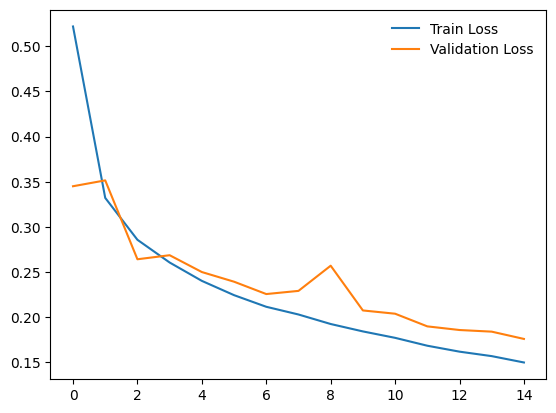

In [10]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.legend(frameon = False)

# Testing The Model

In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on Training set: {check_accuracy(train_loader, model) * 100:.2f}%")
print(f"Accuracy on Test set: {check_accuracy(test_loader, model) * 100:.2f}%")

Accuracy on Training set: 95.19%
Accuracy on Test set: 93.40%


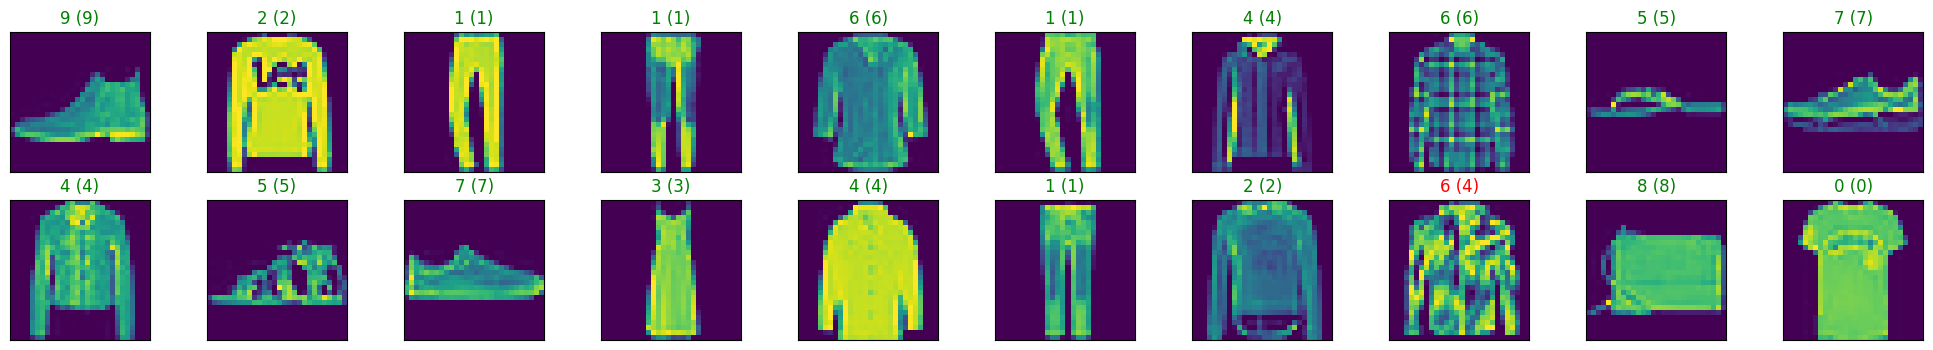

In [12]:
dataiter = iter(test_loader)
data, targets = next(dataiter)

data, targets = data.to(device), targets.to(device)

output = model(data)

_, preds = torch.max(output, 1)

data = data.cpu().numpy()
targets = targets.cpu().numpy()
preds = preds.cpu().numpy()

data = data.squeeze()

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    ax.imshow(data[idx])
    ax.set_title("{} ({})".format(str(preds[idx]), str(targets[idx])),
                 color=("green" if preds[idx] == targets[idx] else "red"))
plt.show()